<a href="https://colab.research.google.com/github/IlyaKo4atkov/My-machine-learning-projects/blob/main/A_model_for_predicting_the_works_of_Russian_writers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Загрузка данных

In [ ]:
!wget https://storage.yandexcloud.net/natasha-navec/packs/navec_hudlit_v1_12B_500K_300d_100q.tar
!pip install navec
from navec import Navec

navec = Navec.load('navec_hudlit_v1_12B_500K_300d_100q.tar')


--2024-10-10 15:59:46--  https://storage.yandexcloud.net/natasha-navec/packs/navec_hudlit_v1_12B_500K_300d_100q.tar
Resolving storage.yandexcloud.net (storage.yandexcloud.net)... 213.180.193.243, 2a02:6b8::1d9
Connecting to storage.yandexcloud.net (storage.yandexcloud.net)|213.180.193.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 53012480 (51M) [application/x-tar]
Saving to: ‘navec_hudlit_v1_12B_500K_300d_100q.tar’

navec_hudlit_v1_12B 100%[===================>]  50.56M  15.9MB/s    in 3.8s    

2024-10-10 15:59:51 (13.2 MB/s) - ‘navec_hudlit_v1_12B_500K_300d_100q.tar’ saved [53012480/53012480]



In [ ]:
!wget https://storage.yandexcloud.net/academy.ai/russian_literature.zip
!pip install razdel==0.5.0 #Загрузка токенизатора Razdel согласно условию задачи

#Разорхировка архива в временную папку
!unzip -qo "russian_literature" -d ./dataset

--2024-10-10 16:00:41--  https://storage.yandexcloud.net/academy.ai/russian_literature.zip
Resolving storage.yandexcloud.net (storage.yandexcloud.net)... 213.180.193.243, 2a02:6b8::1d9
Connecting to storage.yandexcloud.net (storage.yandexcloud.net)|213.180.193.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 21547079 (21M) [application/x-zip-compressed]
Saving to: ‘russian_literature.zip’

russian_literature. 100%[===================>]  20.55M  7.85MB/s    in 2.6s    

2024-10-10 16:00:44 (7.85 MB/s) - ‘russian_literature.zip’ saved [21547079/21547079]

error:  cannot create ./dataset/poems/Blok/╨б╤В╨╕╤Е╨╛╤В╨▓╨╛╤А╨╡╨╜╨╕╤П 1897-1903 ╨│╨│, ╨╜╨╡ ╨▓╨╛╤И╨╡╨┤╤И╨╕╨╡ ╨▓ ╨╛╤Б╨╜╨╛╨▓╨╜╨╛╨╡ ╤Б╨╛╨▒╤А╨░╨╜╨╕╨╡.txt
        File name too long
error:  cannot create ./dataset/prose/Gogol/╨Я╨╛╨▓╨╡╤Б╤В╤М ╨╛ ╤В╨╛╨╝, ╨║╨░╨║ ╨┐╨╛╤Б╤Б╨╛╤А╨╕╨╗╤Б╤П ╨Ш╨▓╨░╨╜ ╨Ш╨▓╨░╨╜╨╛╨▓╨╕╤З ╤Б ╨Ш╨▓╨░╨╜╨╛╨╝ ╨Э╨╕╨║╨╕╤Д╨╛╤А╨╛╨▓╨╕╤З╨╡╨╝.txt
        File name too long
error:  cannot create ./dataset/publi

In [ ]:

# Загрузка необходимых библиотек
import glob # Вспомогательный модуль для работы с файловой системой
import numpy as np
from keras import utils
from keras.models import Sequential
from keras.layers import Dense, Dropout, SpatialDropout1D, BatchNormalization, Embedding, Flatten, Activation
from razdel import tokenize, sentenize
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay # Для работы с матрицей ошибок

# Выбираем их явно, чтобы список был перед глазами, и отложилось в голове, что имена писателей (точнее их порядковый номер) - это метки
CLASS_LIST=["Dostoevsky", "Tolstoy", "Gorky", "Turgenev", "Gogol"] # -- берем 5 представителей класса, согласно условию задачи
all_texts = {} #собираем в словарь весь датасет
for author in CLASS_LIST:
  all_texts[author] = '' # Инициализируем пустой строкой новый ключ словаря
  for path in glob.glob('./dataset/prose/{}/*.txt'.format(author)) +  glob.glob('./dataset/poems/{}/*.txt'.format(author)): # Поиск файлов по шаблону
    with open(f'{path}', 'r', errors='ignore') as f: # игнорируем ошибки (например символы из другой кодировки)
                # Загрузка содержимого файла в строку
                text = f.read()

    all_texts[author]  += ' ' + text.replace('\n', ' ') # Заменяем символ перехода на новую строку пробелом

# используем генератор цикла для получения длины текстов по каждому автору
total = sum(len(i) for i in all_texts.values())
print(f'Датасет состоит из {total} символов')

Датасет состоит из 29479981 символов


Общая выборка по писателям:
Dostoevsky - 11221679 символов, доля в общей базе: 38.07%
Tolstoy - 9392435 символов, доля в общей базе: 31.86%
Gorky - 4324025 символов, доля в общей базе: 14.67%
Turgenev - 2345243 символов, доля в общей базе: 7.96%
Gogol - 2196599 символов, доля в общей базе: 7.45%


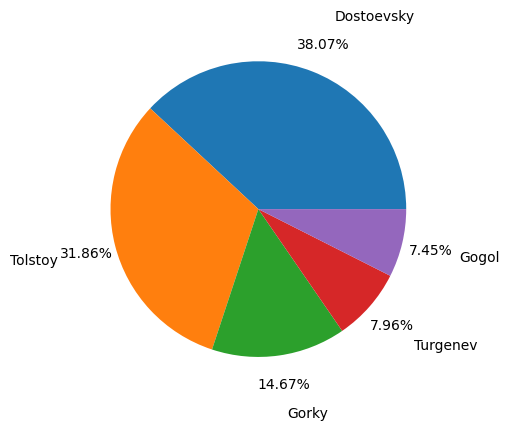

In [ ]:
#Вывод общей выборки по писателям
print('Общая выборка по писателям:')
for author in CLASS_LIST:
    # удобный метод форматирования 2 знака после запятой f'{ВЫРАЖЕНИЕ:.2f}'
    print(f'{author} - {len(all_texts[author])} символов, доля в общей базе: {len(all_texts[author])/total*100 :.2f}%')

import matplotlib.pyplot as plt
%matplotlib inline
fig, ax = plt.subplots()
ax.pie([len(i) for i in all_texts.values()], # формируем список значений как длина символов текста каждого автора
       labels=CLASS_LIST,                    # список меток
       pctdistance=1.2,                      # дистанция размещения % (1 - граница окружности)
       labeldistance=1.4,                    # размещение меток (1 - граница окружности)
       autopct='%1.2f%%'                     # формат для % (2 знака после запятой)
      )
plt.show()

### Токенизация

In [ ]:

from collections import Counter
from razdel import tokenize
max_words = 10000
# Функция для токенизации текста с помощью Razdel
def razdel_tokenize(text):
    return [token.text for token in tokenize(text)]

# Создаем частотный словарь
word_counter = Counter()

for text in all_texts.values():
    tokens = razdel_tokenize(text)
    word_counter.update(tokens)

# Ограничиваем словарь max_words наиболее частотными словами
most_common_words = [word for word, _ in word_counter.most_common(max_words)]

# Создаем словарь для преобразования слов в индексы
word_index = {word: i+1 for i, word in enumerate(most_common_words)}

# Преобразуем тексты в последовательности индексов
seq_train = []
for text in all_texts.values():
    tokens = razdel_tokenize(text)
    seq = [word_index.get(token, 0) for token in tokens]  # 0 для слов, которых нет в словаре
    seq_train.append(seq)

# Балансировка данных
seq_train_balance = [seq_train[cls][:40000] for cls in range(len(CLASS_LIST))]

# используем генератор цикла для получения длины текстов по каждому автору
total = sum(len(i) for i in seq_train_balance)
print(f'Датасет состоит из {total} слов')

import numpy as np

print('Общая выборка по писателям (по словам):')
mean_list = np.array([])
for author in CLASS_LIST:
    cls = CLASS_LIST.index(author)
    print(f'{author} - {len(seq_train_balance[cls])} слов, доля в общей базе: {len(seq_train_balance[cls])/total*100 :.2f}%')
    mean_list = np.append(mean_list, len(seq_train_balance[cls]))

print('Среднее значение слов: ', np.round(mean_list.mean()))
print('Медианное значение слов: ', np.median(mean_list))

Датасет состоит из 200000 слов
Общая выборка по писателям (по словам):
Dostoevsky - 40000 слов, доля в общей базе: 20.00%
Tolstoy - 40000 слов, доля в общей базе: 20.00%
Gorky - 40000 слов, доля в общей базе: 20.00%
Turgenev - 40000 слов, доля в общей базе: 20.00%
Gogol - 40000 слов, доля в общей базе: 20.00%
Среднее значение слов:  40000.0
Медианное значение слов:  40000.0


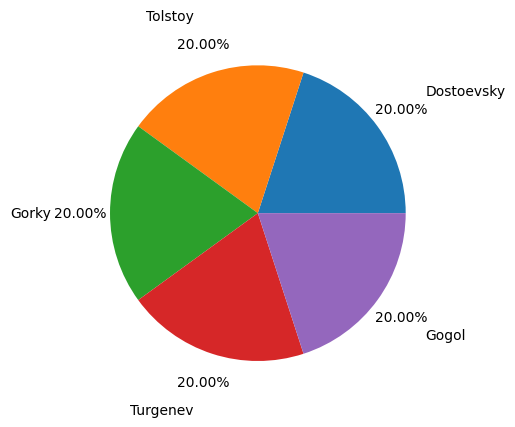

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
fig, ax = plt.subplots()
ax.pie([len(i) for i in seq_train_balance], # формируем список значений как длина символов текста каждого автора
       labels=CLASS_LIST,                    # список меток
       pctdistance=1.2,                      # дистанция размещения % (1 - граница окружности)
       labeldistance=1.4,                    # размещение меток (1 - граница окружности)
       autopct='%1.2f%%'                     # формат для % (2 знака после запятой)
      )
plt.show()

### Нарезка примеров из текста методом скользящего окна

In [ ]:
WIN_SIZE = 1000   # Ширина окна в токенах
WIN_STEP = 100    # Шаг окна в токенах

# Функция разбиения последовательности на отрезки скользящим окном
# Последовательность разбивается на части до последнего полного окна
# Параметры:
# sequence - последовательность токенов
# win_size - размер окна
# step - шаг окна
def seq_split(sequence, win_size, step):
    # Делим строку на отрезки с помощью генератора цикла
    return [sequence[i:i + win_size] for i in range(0, len(sequence) - win_size + 1, step)]

def seq_vectorize(
    seq_list,   # Последовательность
    test_split, # Доля на тестовую сборку
    class_list, # Список классов
    win_size,   # Ширина скользящего окна
    step        # Шаг скользящего окна
):

    # Списки для результирующих данных
    x_train, y_train, x_test, y_test =  [], [], [], []

    # Пробежимся по всем классам:
    for class_item in class_list:
        # Получим индекс класса
        cls = class_list.index(class_item)

        # Пороговое значение индекса для разбивки на тестовую и обучающую выборки
        gate_split = int(len(seq_list[cls]) * (1-test_split))

        # Разбиваем последовательность токенов класса на отрезки
        vectors_train = seq_split(seq_list[cls][:gate_split], win_size, step) # последовательность до порога попадет в обучающую выборку
        vectors_test = seq_split(seq_list[cls][gate_split:], win_size, step)  # последовательность после порога попадет в тестовую выборку

        # Добавляем отрезки в выборку
        x_train += vectors_train
        x_test += vectors_test

        # Для всех отрезков класса добавляем метки класса в виде one-hot-encoding
        # Каждую метку берем len(vectors) раз, так она одинакова для всех выборок одного класса
        y_train += [utils.to_categorical(cls, len(class_list))] * len(vectors_train)
        y_test += [utils.to_categorical(cls, len(class_list))] * len(vectors_test)

    # Возвращаем результатов как numpy-массивов
    return np.array(x_train), np.array(y_train), np.array(x_test), np.array(y_test)


In [ ]:
x_train, y_train, x_test, y_test = seq_vectorize(seq_train_balance, 0.1, CLASS_LIST, WIN_SIZE, WIN_STEP)

In [ ]:
print(f'Форма входных данных для обучающей выборки: {x_train.shape}')
print(f'Форма выходных данных (меток) для обучающей выборки: {y_train.shape}')

print(f'Форма входных данных для тестовой выборки: {x_test.shape}')
print(f'Форма выходных данных (меток) для тестовой выборки: {y_test.shape}')

Форма входных данных для обучающей выборки: (1755, 1000)
Форма выходных данных (меток) для обучающей выборки: (1755, 5)
Форма входных данных для тестовой выборки: (155, 1000)
Форма выходных данных (меток) для тестовой выборки: (155, 5)


### Определение вспомогательных функций

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay # Для работы с матрицей ошибок

# Вывод графиков точности и ошибки
def show_plot(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 5))
    fig.suptitle('График процесса обучения модели')
    ax1.plot(history.history['accuracy'],
               label='График точности на обучающей выборке')
    ax1.plot(history.history['val_accuracy'],
               label='График точности на проверочной выборке')
    ax1.xaxis.get_major_locator().set_params(integer=True) # На оси х показываем целые числа
    ax1.set_xlabel('Эпоха обучения')
    ax1.set_ylabel('График точности')
    ax1.legend()

    ax2.plot(history.history['loss'],
               label='Ошибка на обучающей выборке')
    ax2.plot(history.history['val_loss'],
               label='Ошибка на проверочной выборке')
    ax2.xaxis.get_major_locator().set_params(integer=True) # На оси х показываем целые числа
    ax2.set_xlabel('Эпоха обучения')
    ax2.set_ylabel('Ошибка')
    ax2.legend()
    plt.show()

# Функция вывода предсказанных значений
def show_confusion_matrix(y_true, y_pred, class_labels):
    # Матрица ошибок
    cm = confusion_matrix(np.argmax(y_true, axis=1),
                          np.argmax(y_pred, axis=1),
                          normalize='true')
    # Округление значений матрицы ошибок
    cm = np.around(cm, 3)

    # Отрисовка матрицы ошибок
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.set_title(f'Матрица ошибок', fontsize=18)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
    disp.plot(ax=ax)
    plt.gca().images[-1].colorbar.remove()  # Убираем ненужную цветовую шкалу
    plt.xlabel('Предсказанные классы', fontsize=16)
    plt.ylabel('Верные классы', fontsize=16)
    fig.autofmt_xdate(rotation=45)          # Наклон меток горизонтальной оси
    plt.show()


    # Средняя точность распознавания определяется как среднее диагональных элементов матрицы ошибок
    print('\nСредняя точность распознавания: {:3.0f}%'.format(100. * cm.diagonal().mean()))


In [ ]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense, SpatialDropout1D, BatchNormalization, Dropout
embedding_dim = 300

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=WIN_SIZE))
model.add(BatchNormalization())
model.add(Dense(40, activation="relu"))
model.add(Dropout(0.6))
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dense(len(CLASS_LIST), activation='softmax'))



/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
import numpy as np
max_words = 10000  # Максимальное количество слов
embedding_dim = 300  # Размерность векторов эмбеддингов

import numpy as np

embeddings_index = navec

embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    if i < max_words:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

In [ ]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = True

In [ ]:
import keras
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Добавляем колбеки, это функции которые выполняются по завершению эпохи в процессе обучения
callbacks = [
    keras.callbacks.ModelCheckpoint(filepath = 'best_model.keras', # имя файла для сохранения лучшей эпохи
                             monitor = 'val_acc', # лучший результат будем расчитывать по значениям точности на проверочной выборке
                             save_best_only = True, # сохраняем только лучший результат
                             mode = 'max', # функция применяемая к параметру monitor (в нашем случаем максимальное значение val_acc)
                             verbose = 0) # не логируем работу колбэка
]

history = model.fit(x_train, y_train, epochs=50, batch_size=64, validation_data=(x_test, y_test), callbacks=callbacks) #использую validation_data, согласно условию задаячи
model.save_weights('pre_trained_model.weights.h5') # можно сохранять не только модели, но и веса



Epoch 1/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 5s 87ms/step - accuracy: 0.9937 - loss: 0.0676 - val_accuracy: 0.9290 - val_loss: 0.9441
Epoch 2/50
13/28 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9966 - loss: 0.0217

/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/model_checkpoint.py:206: UserWarning: Can save best model only with val_acc available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)


28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9955 - loss: 0.0491 - val_accuracy: 0.9419 - val_loss: 0.8018
Epoch 3/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 1.0000 - loss: 1.0477e-04 - val_accuracy: 0.9161 - val_loss: 1.1092
Epoch 4/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9977 - loss: 0.0247 - val_accuracy: 0.8968 - val_loss: 1.7691
Epoch 5/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9990 - loss: 0.0028 - val_accuracy: 0.8903 - val_loss: 2.4564
Epoch 6/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9994 - loss: 0.0045 - val_accuracy: 0.9226 - val_loss: 0.8737
Epoch 7/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9985 - loss: 0.0037 - val_accuracy: 0.9355 - val_loss: 1.0542
Epoch 8/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9977 - loss: 0.0260 - val_accuracy: 0.9226 - val_loss: 1.1037
Epoch 9/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 8.5024e-07 - val_accuracy: 0.9161 - val_

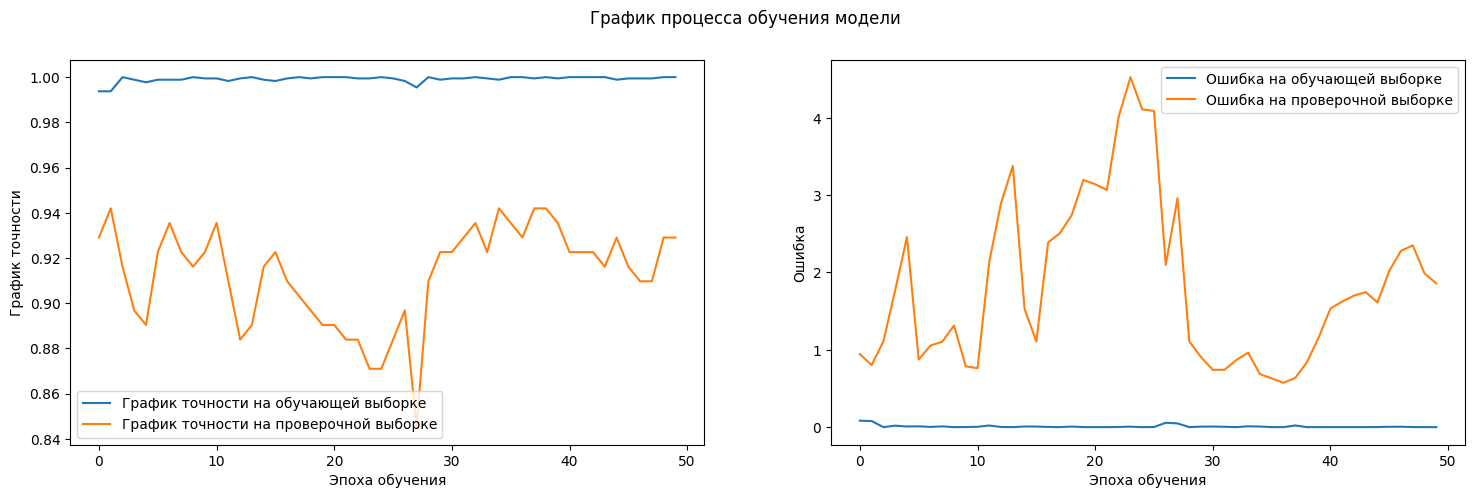

In [ ]:
show_plot(history)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


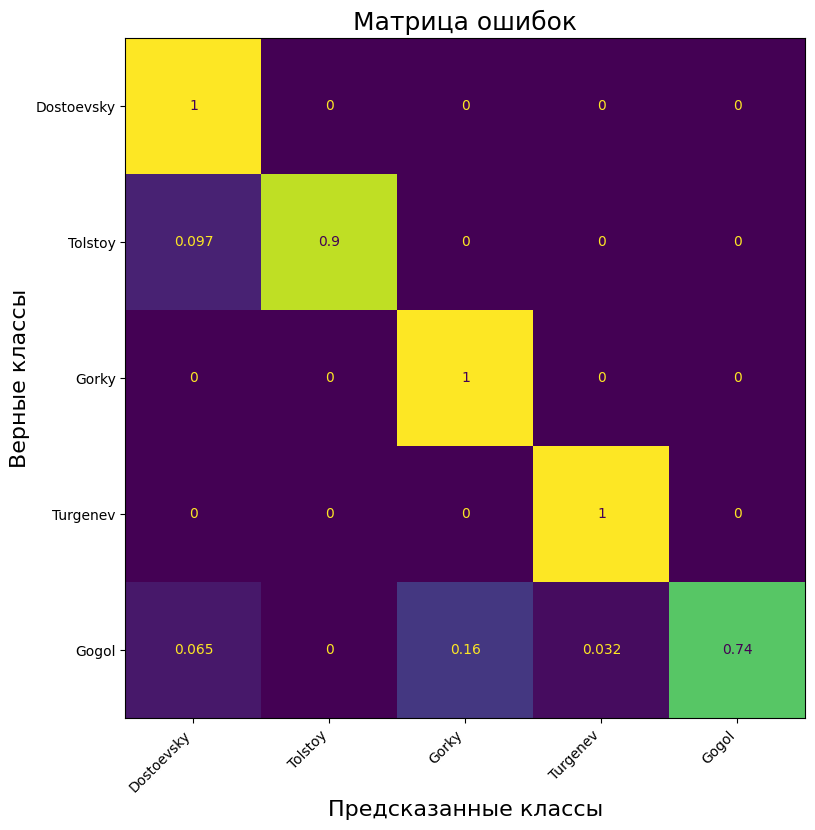


Средняя точность распознавания:  93%


In [ ]:
y_pred = model.predict(x_test)
show_confusion_matrix(y_test, y_pred, CLASS_LIST)